In [139]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from collections import Counter
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import cross_val_score, train_test_split

from xgboost.sklearn import XGBRegressor
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize, BayesSearchCV

import shap
import eli5
from eli5.sklearn import PermutationImportance

In [91]:
df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')

In [92]:
df.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


## 1. Feature engineering

In [93]:
# Aa function for encoding NaN's to zeros and other values to ones of a selected feature
def binary_encode(feature):
    encoder = lambda x: 0 if pd.isna(x) else 1
    df[feature] = df[feature].apply(encoder)
    test_df[feature] = test_df[feature].apply(encoder)

In [94]:
# Convert homepage and belongs_to_collection to binary values
binary_encode('homepage')
binary_encode('belongs_to_collection')

In [95]:
# Create a binary feature showing if original language is english
english_identifier = lambda lang: 1 if lang == 'en' else 0

df['english_original'] = df['original_language'].apply(english_identifier)
test_df['english_original'] = test_df['original_language'].apply(english_identifier)

In [96]:
# A set of functions that will be used for counting the most frequent companies, cast and genres that appear in movies
extract_names = lambda companies: [company['name'] for company in eval(companies)] if pd.notna(companies) else []
top_x = lambda top_count, list_of_items: [item[0] for item in Counter([i for j in list_of_items for i in j]).most_common(top_count)]

def count_top(x, top):
    counter = 0
    for name in x:
        if name in top:
            counter += 1
    return counter

In [97]:
# Count number of top 20 production_companies in a movie
top_10_companies = top_x(20, df['production_companies'].apply(extract_names).values)

df['num_top_companies'] = df['production_companies'].apply(extract_names).apply(count_top, args=(top_10_companies,))
test_df['num_top_companies'] = test_df['production_companies'].apply(extract_names).apply(count_top, args=(top_10_companies,))

In [98]:
# Count number of top 5 genres in a movie
top_5_genres = top_x(5, df['genres'].apply(extract_names).values)

df['num_top_genres'] = df['genres'].apply(extract_names).apply(count_top, args=(top_5_genres,))
test_df['num_top_genres'] = test_df['genres'].apply(extract_names).apply(count_top, args=(top_5_genres,))

In [99]:
# Count number of top 50 cast in a movie
top_50_cast = top_x(50, df['cast'].apply(extract_names).values)

df['num_top_cast'] = df['cast'].apply(extract_names).apply(count_top, args=(top_50_cast,))
test_df['num_top_cast'] = test_df['cast'].apply(extract_names).apply(count_top, args=(top_50_cast,))

In [100]:
# Count number of items in a list and make the result a feature
def count_num(feature):
    name = 'num_' + feature
    counter = lambda x: np.nan if pd.isna(x) else len(eval(x))
    df[name] = df[feature].apply(counter)
    test_df[name] = test_df[feature].apply(counter)

In [101]:
# Count number of genres, spoken_languages, production_companies, production_countries, cast, crew, Keywords
# and create new features from them
for feature in ['genres', 'spoken_languages', 'production_companies', 'production_countries', 'cast', 'crew', 'Keywords']:
    count_num(feature)

In [102]:
# Some processed features had NaN values, fill them with median
for feature in ['num_genres', 'num_spoken_languages', 'num_production_companies', 'num_production_countries', 'num_cast', 'num_crew', 'num_Keywords']:
    df[feature] = df[feature].fillna(df[feature].median())
    test_df[feature] = test_df[feature].fillna(test_df[feature].median())

In [103]:
# Noticed that 'runtime' has two nulls and 12 zero values, let's fill them with median
df.loc[df['runtime'] == 0, 'runtime'] = df['runtime'].median()
test_df.loc[test_df['runtime'] == 0, 'runtime'] = test_df['runtime'].median()

df['runtime'] = df['runtime'].fillna(df['runtime'].median())
test_df['runtime'] = test_df['runtime'].fillna(test_df['runtime'].median())

In [104]:
# Fix null release_date in test dataset
test_df.loc[test_df['release_date'].isnull() == True, 'release_date'] = '12/8/01'

In [105]:
# Since years in release dates are represented as 19 and 20, this will change them to 19xx and 20xx respectively
def fix_year(date):
    year = date.split('/')[2]
    if int(year) < 19:
        return date[:-2] + "20" + year
    else:
        return date[:-2] + "19" + year

In [106]:
df['release_date'] = df['release_date'].apply(lambda x: fix_year(x))
test_df['release_date'] = test_df['release_date'].apply(lambda x: fix_year(x))

df['release_date'] = pd.to_datetime(df['release_date'])
test_df['release_date'] = pd.to_datetime(test_df['release_date'])

In [107]:
# Make separate features from month, day, weekday and year of release dates
df['year'] = df['release_date'].apply(lambda x: x.year)
test_df['year'] = test_df['release_date'].apply(lambda x: x.year)

df['month'] = df['release_date'].apply(lambda x: x.month)
test_df['month'] = test_df['release_date'].apply(lambda x: x.month)

df['day'] = df['release_date'].apply(lambda x: x.day)
test_df['day'] = test_df['release_date'].apply(lambda x: x.day)

In [108]:
# Create features for positivity, neurality and negativity of the movie overview using VADER sentiment analyser
analyser = SentimentIntensityAnalyzer()

df['overview_positivity'] = df['overview'].apply(lambda sentence: analyser.polarity_scores(str(sentence))['pos'])
test_df['overview_positivity'] = test_df['overview'].apply(lambda sentence: analyser.polarity_scores(str(sentence))['pos'])

df['overview_neutrality'] = df['overview'].apply(lambda sentence: analyser.polarity_scores(str(sentence))['neu'])
test_df['overview_neutrality'] = test_df['overview'].apply(lambda sentence: analyser.polarity_scores(str(sentence))['neu'])

df['overview_negativity'] = df['overview'].apply(lambda sentence: analyser.polarity_scores(str(sentence))['neg'])
test_df['overview_negativity'] = test_df['overview'].apply(lambda sentence: analyser.polarity_scores(str(sentence))['neg'])

In [109]:
# Drop columns that are not gonna be used, but save test id
test_id = test_df['id']

columns = ['id', 'imdb_id', 'poster_path', 'genres', 'original_language', 'original_title', 'overview', 'production_companies', 
           'production_countries', 'release_date','spoken_languages', 'status', 'tagline', 'title', 'Keywords', 'cast', 'crew']

df.drop(columns, axis=1, inplace=True)
test_df.drop(columns, axis=1, inplace=True)

In [110]:
df.head()

,belongs_to_collection,budget,homepage,popularity,runtime,revenue,english_original,num_top_companies,num_top_genres,num_top_cast,num_genres,num_spoken_languages,num_production_companies,num_production_countries,num_cast,num_crew,num_Keywords,year,month,day,overview_positivity,overview_neutrality,overview_negativity
0,1,14000000,0,6.575393,93.0,12314651,1,3,1,1,1.0,1.0,3.0,1.0,24.0,72.0,4.0,2015,2,20,0.184,0.747,0.069
1,1,40000000,0,8.248895,113.0,95149435,1,1,3,0,4.0,1.0,1.0,1.0,20.0,9.0,4.0,2004,8,6,0.098,0.844,0.058
2,0,3300000,1,64.299990,105.0,13092000,1,0,1,1,1.0,1.0,3.0,1.0,51.0,64.0,12.0,2014,10,10,0.292,0.708,0.000
3,0,1200000,1,3.174936,122.0,16000000,0,0,2,0,2.0,2.0,2.0,1.0,7.0,3.0,7.0,2012,3,9,0.106,0.794,0.100
4,0,0,0,1.148070,118.0,3923970,0,0,2,0,2.0,1.0,2.0,1.0,4.0,2.0,6.0,2009,2,5,0.000,0.751,0.249


## 2. Plotting relations

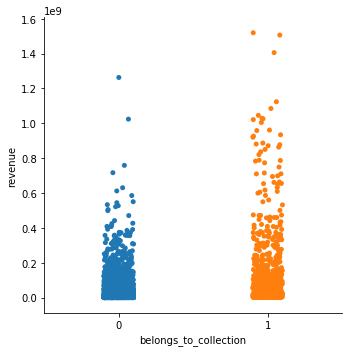

In [111]:
# Revenue for movies belonging to collection vs movies that don't belong to a collection
sns.catplot(x='belongs_to_collection', y='revenue', data=df)

From the plot we can see that some movies that belong to a collection manage to make a bigger revenue.
Probably because they have a bigger fan base.

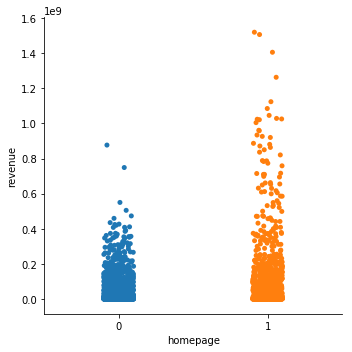

In [112]:
# Revenue for movies with a homepage vs movies without one
sns.catplot(x='homepage', y='revenue', data=df)

The plot tells us that movies with a homepage tend to make a much bigger revenue than movies without one.

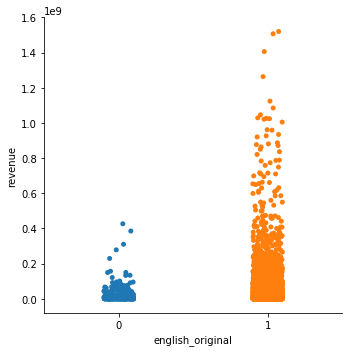

In [113]:
sns.catplot(x='english_original', y='revenue', data=df)

Movies where english is the original language tend to make way higher revenues, also most of the movies in this dataset have their original language as english.

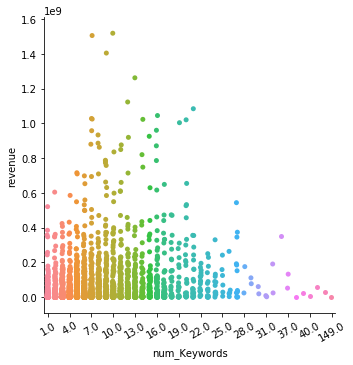

In [114]:
plot = sns.catplot(x='num_Keywords', y='revenue', data=df)
plot.set_xticklabels(step=3, rotation=30)

This graph tells us that movies that have between 5 and about 20 keywords also have the highest revenue values.

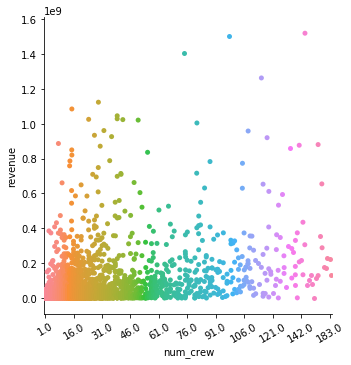

In [115]:
plot = sns.catplot(x='num_crew', y='revenue', data=df)
plot.set_xticklabels(step=15, rotation=30)

It seems that the crew size isn't really impacting the revenue of a movie.

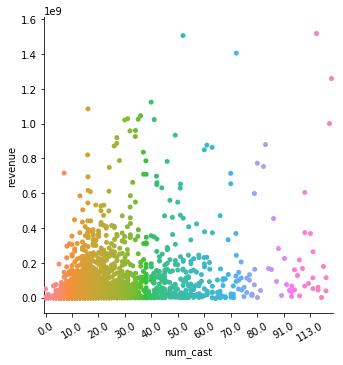

In [116]:
plot = sns.catplot(x='num_cast', y='revenue', data=df)
plot.set_xticklabels(step=10, rotation=30)

Same goes for the cast size.

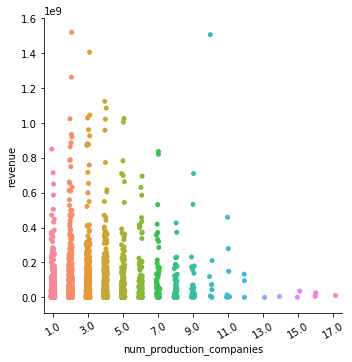

In [117]:
plot = sns.catplot(x='num_production_companies', y='revenue', data=df)
plot.set_xticklabels(step=2, rotation=30)

From the graph we can see that the highest revenue belongs to the movies that have 1-5 production companies involved.
Also it seems like there is one **OUTLIER** where a movie with 10 production companies has got a very high revenue.

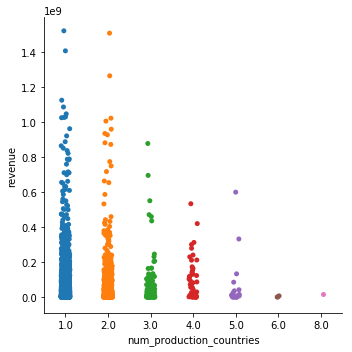

In [118]:
sns.catplot(x='num_production_countries', y='revenue', data=df)

Movies with the highest revenue have only 1 or 2 countries involved in production.

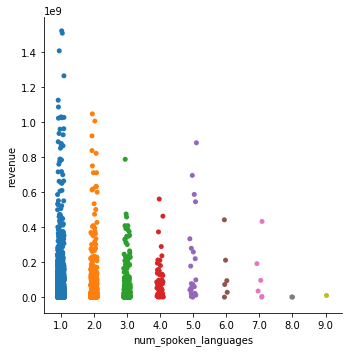

In [119]:
sns.catplot(x='num_spoken_languages', y='revenue', data=df)

Most of the movies have only 1 or 2 spoken languages.
The highest revenues belong to movies that have one spoken language, surely it's english.

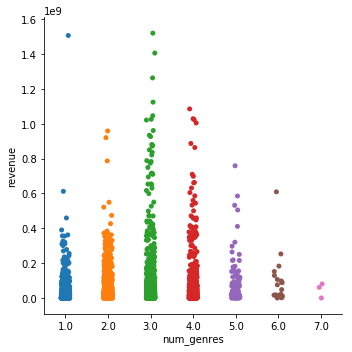

In [120]:
sns.catplot(x='num_genres', y='revenue', data=df)

Interestingly, highest revenue is made by movies that have a combination of 3 genres.

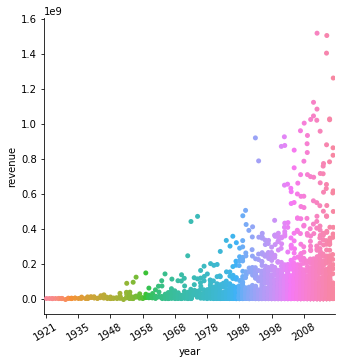

In [121]:
plot = sns.catplot(x='year', y='revenue', data=df)
plot.set_xticklabels(step=10, rotation=30)

From this plot we can clearly see that movies started making way bigger revenues starting from about year 1990 and the revenues saw a big jump from 2010 onwards.

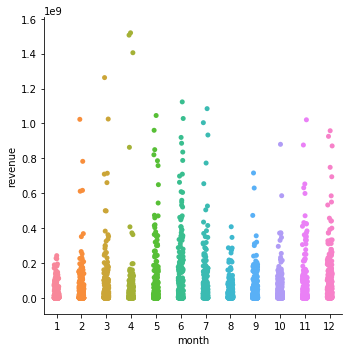

In [122]:
sns.catplot(x='month', y='revenue', data=df)

This graph shows that movies released mid-summer and early-winter tend to have highest revenues

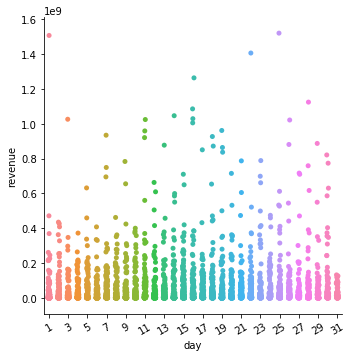

In [123]:
plot = sns.catplot(x='day', y='revenue', data=df)
plot.set_xticklabels(step=2, rotation=30)

Interestingly, movies released in the beggining of the month have lower revenues than those released later on

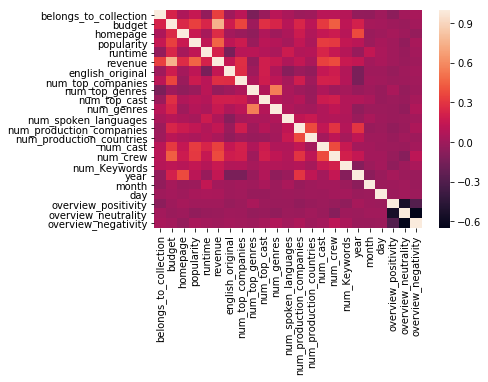

In [124]:
sns.heatmap(df.corr(), xticklabels=list(df), yticklabels=list(df))

**Budget and popularity have the highest correlation with revenue.**

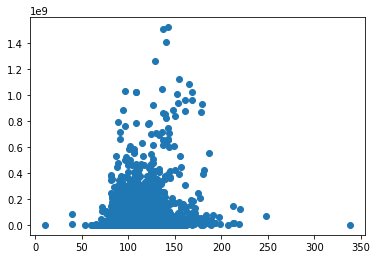

In [125]:
plt.scatter(df['runtime'], df['revenue'])

This graph shows us that movies with a runtime from about 80 to about 180 minutes have the highest revenues.
Not too long and not too short I guess.

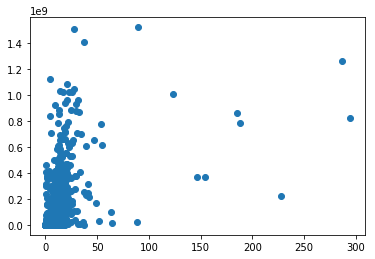

In [126]:
plt.scatter(df['popularity'], df['revenue'])

Not quite sure what is represented by popularity here. But the graph seems to show that most movies have a low popularity rating, while really popular movies tend to have higher than average revenues.

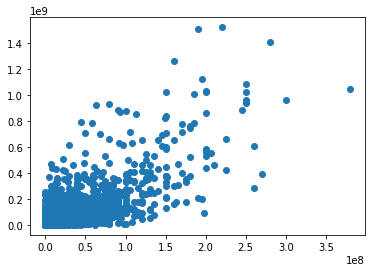

In [127]:
plt.scatter(df['budget'], df['revenue'])

Finally, the most correlated variable - **budget**.
It seems that we have a linear relationship between budget and revenue. Meaning in most cases, the higher the budget, the higher the revenue.

## 3. Try out different base regressors

In [128]:
# Create separate variables for models to use as features and labels when fitting
labels = df['revenue']
df.drop('revenue', axis=1, inplace=True)

In [129]:
def score_model(model):
    scores = cross_val_score(model, df, labels, scoring="neg_mean_squared_error", cv=10)
    return np.sqrt(-scores).mean().round()

In [130]:
# Print mean error using cross validation
print('XGB: ', score_model(XGBRegressor()))
print('Linear: ', score_model(LinearRegression()))
print('Decision Tree: ', score_model(DecisionTreeRegressor()))
print('SVR auto: ', score_model(SVR(gamma='auto')))
print('Random Forest: ', score_model(RandomForestRegressor(n_estimators=10)))
print('Gradient Boosting: ', score_model(GradientBoostingRegressor()))
print('Ada Boost: ', score_model(AdaBoostRegressor()))

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/x

XGB:  76551439.0
Linear:  81848982.0
Decision Tree:  107670375.0
SVR auto:  145237741.0
Random Forest:  81979600.0
Gradient Boosting:  76810294.0
Ada Boost:  119400826.0


## 4. Skopt hyperparameter optimization

In [131]:
features_train, features_test, labels_train, labels_test = train_test_split(df, labels, random_state=42)

In [132]:
def print_scores(model):
    print("validation score: %s" % np.sqrt(-model.best_score_))
    print("test score: %s" % np.sqrt(-model.score(features_test, labels_test)))

### Gradient Boosting Regressor

In [133]:
params = {
    'learning_rate': (10**-5, 10**0),
    'n_estimators': (100, 1000),
    'max_features': (1, len(list(df))),
    'min_samples_split': (2, 100),
    'subsample': (0.1, 1)
}

gradient = BayesSearchCV(GradientBoostingRegressor(), params, n_iter=32, cv=5, scoring="neg_mean_squared_error")

gradient.fit(features_train, labels_train)

print('Gradient Boost Scores')
print_scores(gradient)

Gradient Boost Scores
validation score: 83563065.90386127
test score: 72684542.00876236


### XGB Regressor

In [134]:
params = {
    'learning_rate': (10**-5, 10**0),
    'n_estimators': (100, 1000),
    'max_features': (1, len(list(df))),
    'min_samples_split': (2, 100),
    'subsample': (0.1, 1)
}

xgb = BayesSearchCV(XGBRegressor(), params, n_iter=32, cv=5, scoring="neg_mean_squared_error")

xgb.fit(features_train, labels_train)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/x

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/x

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/x

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/x

BayesSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
       fit_params=None, iid=True, n_iter=32, n_jobs=1, n_points=1,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
       refit=True, return_train_score=False,
       scoring='neg_mean_squared_error',
       search_spaces={'learning_rate': (1e-05, 1), 'n_estimators': (100, 1000), 'max_features': (1, 22), 'min_samples_split': (2, 100), 'subsample': (0.1, 1)},
       verbose=0)

In [135]:
print('XGB Scores')
print_scores(xgb)

XGB Scores
validation score: 81830013.04470734
test score: 71508900.67267399


### Random Forest Regressor

In [136]:
params = {
    'n_estimators': (10, 1000),
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': (2, 100),
    'min_samples_leaf': (1, 10),
    'min_impurity_decrease': (0.0, 1.0)
}

forest = BayesSearchCV(RandomForestRegressor(), params, n_iter=32, cv=5, scoring="neg_mean_squared_error")

forest.fit(features_train, labels_train)

print('Random Forest Scores')
print_scores(forest)
print("Best params:")
print(forest.best_params_)

Random Forest Scores
validation score: 82115538.22958565
test score: 71637377.98644765
Best params:
{'max_features': 'log2', 'min_impurity_decrease': 0.8197065905966038, 'min_samples_leaf': 3, 'min_samples_split': 14, 'n_estimators': 780}


### The Random Forest Regressor is yielding the worst test score, but since it doesn't produce negative values it will be used final predictions

## 5. Fitting the final model on all of the train data

In [140]:
reg = RandomForestRegressor(**forest.best_params_, random_state=42)
reg.fit(df, labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.8197065905966038,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=14, min_weight_fraction_leaf=0.0,
           n_estimators=780, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

## 6. A look at what's most important for the model

In [142]:
perm = PermutationImportance(reg, random_state=42).fit(features_test, labels_test)
eli5.show_weights(perm, feature_names = features_test.columns.tolist())

Weight,Feature
0.3632 ± 0.0239,budget
0.1286 ± 0.0121,popularity
0.0949 ± 0.0117,belongs_to_collection
0.0533 ± 0.0126,homepage
0.0499 ± 0.0134,num_cast
0.0452 ± 0.0102,runtime
0.0415 ± 0.0056,num_crew
0.0360 ± 0.0075,num_top_companies
0.0278 ± 0.0047,num_Keywords
0.0172 ± 0.0030,num_genres


According to this, **budget**, **popularity** and whether a movie **belongs to a collection** are by far the most important features for the regressor.

In [165]:
data_for_prediction = test_df.iloc[1998]

explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(data_for_prediction)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

## 7. Submission

In [138]:
pred = reg.predict(test_df)
pd.DataFrame({'id': test_id, 'revenue': pred}).to_csv('submissions.csv', index=False)